- время с последнего предложения для пользователя
- скидка это treatment =1? (есть 10% кто не получил скидку)
- есть ли информация за n дней до скидки - для обоих компаний
- группировать по юзерам

- удаляем ли из кампании тех, у кого нет покупок # campaigns = campaigns[campaigns.customer_id.isin(set(receipts.customer_id))]

- нужно отобрать людей, которые сильно реагируют на скидку (при разбиении на группы будет большая прибыль)
- Интерес в том чтобы понять на каких людей мы можем повлиять – которые без воздействия не совершили бы покупку

Нужно совершать воздействие, когда
А) действие принесет пользу
Б) польза будет больше чем если не сорвешать воздействие

uY(xi)=E[Y∣X=xi,T=1]−E[Y∣X=xi,T=0]

In [161]:
import os

import pandas as pd
import numpy as np
import dask.dataframe as dd
import pickle
import json
import sklearn.base as skbase
import sklearn.pipeline as skpipe
import datetime
import matplotlib.pyplot as plt

In [162]:
# import sys
# sys.path.append('uplift-campaign/')

# import upcampaign.datalib as datalib
# import upcampaign.datalib.connection as connection
# import upcampaign.datalib.features.compute as fcompute
# # import upcampaign.model_utils as mu

In [163]:
import lightgbm as lgb
import causalml.metrics as cmetrics
import causalml.inference.meta.rlearner as rlearner

from sklearn.model_selection import train_test_split

In [164]:
ls data

campaigns.csv  customers.csv  receipts.parquet


In [165]:
data_root_path = 'data/'

In [166]:
campaigns = dd.read_csv(os.path.join(data_root_path, 'campaigns.csv')).compute()#.sample(0.01)
customers = dd.read_csv(os.path.join(data_root_path, 'customers.csv')).compute()#.sample(0.01)
receipts = dd.read_parquet(os.path.join(data_root_path, 'receipts.parquet/')).compute()#.sample(0.01)

In [167]:
len(campaigns), len(customers), len(receipts)

(500000, 2000000, 31741769)

In [168]:
from typing import List

In [169]:
def one_hot_encode(data: pd.DataFrame, cols: List[str] = None) -> pd.DataFrame:
    if cols is None:
        cols = data.columns
    result = pd.concat([data, dd.get_dummies(data[cols])], axis=1).drop(cols, axis=1)
    return result

In [59]:
customers = one_hot_encode(customers, cols=['location'])
customers = customers.drop('Unnamed: 0', axis=1)

In [60]:
customers.head()

,customer_id,age,location_Beauclair,location_Crows_perch,location_Hindarsfjall,location_Kaer_Trolde,location_Novigrad,location_Oxenfurt,location_Spikeroog
0,0,56,0,0,0,0,0,1,0
1,1,53,0,0,1,0,0,0,0
2,2,41,0,0,1,0,0,0,0
3,3,60,0,0,0,1,0,0,0
4,4,22,0,0,0,0,0,0,1


In [61]:
customers.nunique()

customer_id              2000000
age                           50
location_Beauclair             2
location_Crows_perch           2
location_Hindarsfjall          2
location_Kaer_Trolde           2
location_Novigrad              2
location_Oxenfurt              2
location_Spikeroog             2
dtype: int64

- Стоит отметить, что покупатель не приобретает фисштех больше одного раза в день

In [62]:
receipts = receipts.drop('purchase_sum', axis=1)

In [63]:
receipts.head()

,customer_id,date,purchase_amt,discount
26,26,0,12.125273,0
53,53,0,34.357035,0
56,56,0,8.695825,0
58,58,0,28.299046,0
64,64,0,32.547511,0


In [64]:
receipts.nunique()

customer_id      1998286
date                 250
purchase_amt    31616098
discount               2
dtype: int64

In [106]:
# set(receipts.customer_id)-set(range(0, 2000000))

set()

In [123]:
receipts_agg = pd.DataFrame(index=set(receipts.customer_id))

In [130]:
102-60

42

In [131]:
receipts_agg['puchase_amt_during_campaign'] = \
    receipts[(receipts.date>=102) & (receipts.date<=108)].groupby('customer_id')['purchase_amt'].sum()

receipts_agg['puchase_amt_15d_before_campaign'] = \
    receipts[(receipts.date>=87) & (receipts.date<102)].groupby('customer_id')['purchase_amt'].sum()

receipts_agg['puchase_amt_30d_before_campaign'] = \
    receipts[(receipts.date>=72) & (receipts.date<102)].groupby('customer_id')['purchase_amt'].sum()

receipts_agg['puchase_amt_60d_before_campaign'] = \
    receipts[(receipts.date>=42) & (receipts.date<102)].groupby('customer_id')['purchase_amt'].sum()

In [134]:
receipts_agg = receipts_agg.fillna(0)

In [136]:
receipts_agg.head()

,puchase_amt_during_campaign,puchase_amt_15d_before_campaign,puchase_amt_30d_before_campaign,puchase_amt_60d_before_campaign
0,9.863892,12.028087,23.426074,64.498275
1,0.000000,0.000000,24.823082,46.727059
2,0.000000,39.133650,39.133650,123.063061
3,20.019053,0.000000,42.392725,107.439304
4,0.000000,0.000000,22.253255,41.160985


In [143]:
receipts_agg['is_campaign'] = 0

In [146]:
receipts_agg.loc[receipts_agg.index<500000, 'is_campaign'] = 1

In [149]:
receipts_agg

,puchase_amt_during_campaign,puchase_amt_15d_before_campaign,puchase_amt_30d_before_campaign,puchase_amt_60d_before_campaign,is_campaign
0,9.863892,12.028087,23.426074,64.498275,1
1,0.000000,0.000000,24.823082,46.727059,1
2,0.000000,39.133650,39.133650,123.063061,1
3,20.019053,0.000000,42.392725,107.439304,1
4,0.000000,0.000000,22.253255,41.160985,1
...,...,...,...,...,...
1999995,20.043122,17.810982,40.704067,84.986137,0
1999996,19.867039,15.677861,51.121022,86.880774,0
1999997,16.599390,12.413591,38.374515,70.094050,0
1999998,0.000000,14.433485,14.433485,23.320969,0


In [150]:
# campaigns = campaigns.drop(['Unnamed: 0', 'n_offer_days', 'target_group_flag'], axis=1)
# campaigns =  campaigns.rename(columns={'date': 'date_start'})
# campaigns['date_end'] = campaigns['date_start'] + 6

In [66]:
# len(set(campaigns.customer_id) - set(receipts.customer_id)), \
# len(set(receipts.customer_id) - set(campaigns.customer_id))

In [67]:
# campaigns.customer_id.min(), campaigns.customer_id.max()

In [68]:
# campaigns.date_start.max(), campaigns.date_end.min()

In [140]:
campaigns.head()

,customer_id,date_start,date_end
0,0,102,108
1,1,102,108
2,2,102,108
3,3,102,108
4,4,102,108


In [70]:
campaigns.nunique()

customer_id    500000
date_start          1
date_end            1
dtype: int64

In [71]:
campaigns[campaigns.customer_id==3566]

,customer_id,date_start,date_end
3566,3566,102,108


In [72]:
len(campaigns), len(customers), len(receipts)

(500000, 2000000, 31741769)

In [152]:
data = receipts.copy()

In [153]:
data['is_campaign'] = 0

In [154]:
data.loc[(data.customer_id<500000) & (data.date>=102) & (data.date<=108), 'is_campaign'] = 1

In [155]:
data.groupby('is_campaign')['discount'].value_counts()

is_campaign  discount
0            0           31493913
1            40            226525
             0              21331
Name: discount, dtype: int64

In [156]:
data[(data.is_campaign==1) & (data.discount==0)]

,customer_id,date,purchase_amt,discount,is_campaign
3566,3566,103,2.528762,0,1
4100,4100,103,2.990367,0,1
4390,4390,103,5.146265,0,1
5556,5556,103,6.404596,0,1
5799,5799,103,3.610522,0,1
...,...,...,...,...,...
499760,499760,108,19.642012,0,1
499771,499771,108,3.569657,0,1
499918,499918,108,2.670410,0,1
499971,499971,108,12.447138,0,1


In [160]:
data[data.customer_id==499760].sort_values('is_campaign').tail()

,customer_id,date,purchase_amt,discount,is_campaign
499760,499760,18,21.505777,0,0
499760,499760,234,5.860275,0,0
499760,499760,247,40.278359,0,0
499760,499760,108,19.642012,0,1
499760,499760,103,19.729092,40,1


In [94]:
campaigns[campaigns.customer_id==3566]

,customer_id,date_start,date_end
3566,3566,102,108


In [97]:
data.customer_id.min(), data.customer_id.max()

(0, 1999999)

In [98]:
data.loc[(data.is_campaign==1) & (data.discount==0), 'is_campaign'] = 0

In [99]:
data.groupby('is_campaign')['discount'].value_counts()

is_campaign  discount
0            0           31515244
1            40            226525
Name: discount, dtype: int64

In [81]:
data = pd.concat([data[data.is_campaign==1], 
           data[data.is_campaign==0].sample(frac=0.1)
          ], axis=0)

In [82]:
data.is_campaign.value_counts()

0    3151524
1     226525
Name: is_campaign, dtype: int64

In [84]:
# data[data.is_campaign==1].discount.value_counts()

In [85]:
# data[data.is_campaign==0].discount.value_counts()

In [86]:
set(data.customer_id)-set(customers.customer_id)

set()

In [87]:
data = data.merge(customers, how='left', on='customer_id')

In [88]:
data.head()

,customer_id,date,purchase_amt,discount,is_campaign,age,location_Beauclair,location_Crows_perch,location_Hindarsfjall,location_Kaer_Trolde,location_Novigrad,location_Oxenfurt,location_Spikeroog
0,12,102,14.351911,40,1,60,0,0,0,0,1,0,0
1,19,102,3.840616,40,1,25,0,0,0,0,1,0,0
2,39,102,12.696186,40,1,24,0,0,1,0,0,0,0
3,72,102,24.732437,40,1,67,0,0,0,0,1,0,0
4,86,102,16.100635,40,1,44,0,1,0,0,0,0,0


# train

In [142]:
fit_index, val_index = train_test_split(data.index, test_size=0.5, random_state=148)

In [143]:
import pylift

In [144]:
col_target = 'purchase_amt'
col_treatment = 'is_campaign'
targ_cols = [col_target, col_treatment]
cols_features  = [c for c in data.columns if c not in targ_cols]

In [145]:
model_n1 = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=165
)

In [146]:
_p_score_const = data.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)
model_n1.fit(
    X=data.loc[fit_index, cols_features].values,
    treatment=data.loc[fit_index, col_treatment].values,
    y=data.loc[fit_index, col_target].values,
    p=_p_scores
)

In [147]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, col_target]]

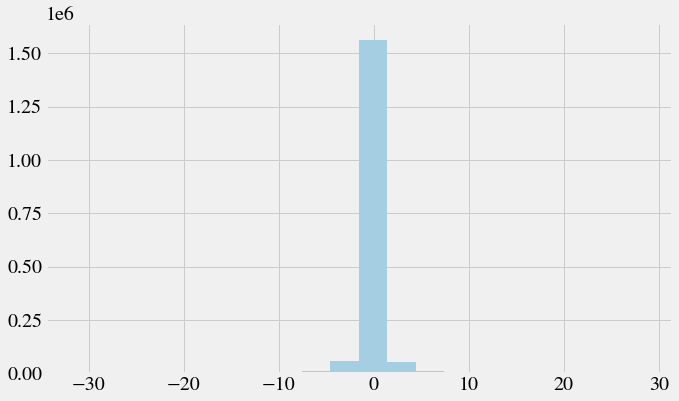

In [148]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=20)
plt.show()

In [149]:
np.percentile(_eval_data['score'], 5) # прибыль на клиента

-1.4281172773321278

In [150]:
np.percentile(_eval_data['score'], 95)

1.061228782876542

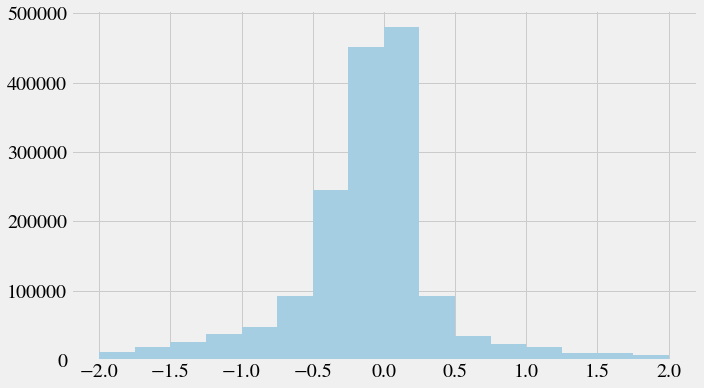

In [151]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], range=(-2, 2), bins=16)
plt.show()

In [152]:
_eval_data['score'].describe()

count    1.698624e+06
mean    -1.258525e-01
std      1.213549e+00
min     -3.151428e+01
25%     -3.322432e-01
50%     -5.096484e-02
75%      7.305881e-02
max      2.840879e+01
Name: score, dtype: float64

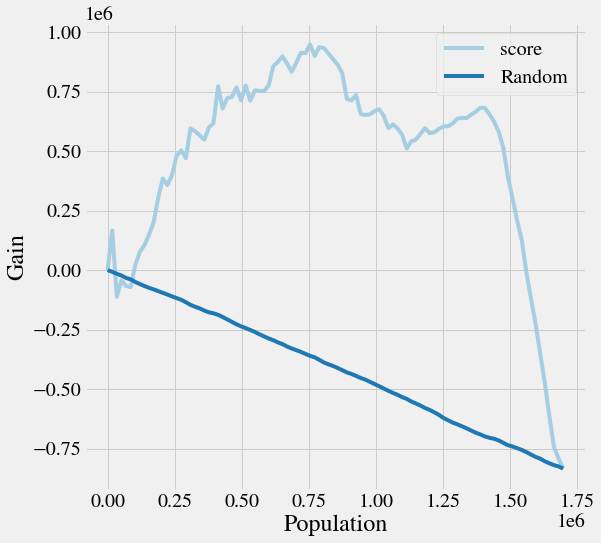

In [153]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)
# топ 25 процентов юзеров - оптимум - по этому значению выбираем порог

In [169]:
np.percentile(_eval_data['score'], 50)

-0.05096483813301808

# predict

In [170]:
model_n_pred = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=165
)

In [171]:
_p_score_const = data.loc[:, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=data.index)
model_n_pred.fit(
    X=data.loc[:, cols_features].values,
    treatment=data.loc[:, col_treatment].values,
    y=data.loc[:, col_target].values,
    p=_p_scores
)

In [180]:
_eval_data = data.loc[:, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n_pred.predict(_eval_data[cols_features])
# _eval_data = _eval_data[['score', col_treatment, col_target]]

In [181]:
_eval_data

,customer_id,date,discount,age,location_Beauclair,location_Crows_perch,location_Hindarsfjall,location_Kaer_Trolde,location_Novigrad,location_Oxenfurt,location_Spikeroog,is_campaign,purchase_amt,score
0,12,102,40,60,0,0,0,0,1,0,0,1,14.351911,-0.089966
1,19,102,40,25,0,0,0,0,1,0,0,1,3.840616,-0.166508
2,39,102,40,24,0,0,1,0,0,0,0,1,12.696186,0.029878
3,72,102,40,67,0,0,0,0,1,0,0,1,24.732437,-0.066026
4,86,102,40,44,0,1,0,0,0,0,0,1,16.100635,-0.203669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397242,1031094,133,0,43,0,0,0,0,0,0,1,0,24.239013,0.491539
3397243,108292,95,0,56,0,0,0,0,1,0,0,0,18.867115,-0.561995
3397244,1014179,132,0,56,0,0,0,0,0,0,1,0,6.208357,0.529218
3397245,1046502,40,0,26,0,0,0,0,1,0,0,0,10.883461,-0.070891


In [190]:
np.percentile(_eval_data['score'], 97)

1.246107631149102

In [192]:
_eval_data.shape

(3397247, 14)

In [201]:
_eval_data[_eval_data['score']>=1.246107631149102][['customer_id']].to_csv('submit.csv', index=False)

In [ ]:
потом обучать на всем датасете с порогом?

# archive

In [53]:
(receipts['purchase_sum']/receipts['purchase_amt']).value_counts().index

Float64Index([80.0, 80.00000000000001, 79.99999999999999], dtype='float64')

In [54]:
receipts[receipts['purchase_sum']/receipts['purchase_amt']==80.00000000000001]

,customer_id,date,purchase_amt,discount,purchase_sum
1881,1881,0,7.391551,0,591.324108
1978,1978,0,13.321760,0,1065.740840
3029,3029,0,14.648189,0,1171.855155
3600,3600,0,15.086169,0,1206.893546
4502,4502,0,15.736323,0,1258.905867
...,...,...,...,...,...
1998880,1998880,249,15.779932,0,1262.394523
1999062,1999062,249,29.840009,0,2387.200757
1999677,1999677,249,15.395928,0,1231.674250
1999800,1999800,249,13.638075,0,1091.046036


In [59]:
receipts[receipts['purchase_sum']/receipts['purchase_amt']==79.99999999999999]['customer_id'].unique()

array([    391,     652,     806, ..., 1993889, 1996231, 1999192])

In [ ]:
# import sqlite3
# conn = sqlite3.connect(":memory:") 
# receipts.to_sql("receipts", conn, index=False)
# campaigns.to_sql("campaigns", conn, index=False)

# # qry = "SELECT * FROM receipts INNER JOIN campaigns WHERE receipts.customer_id=campaigns.customer_id"
# # rec_camp_merge_df = pd.read_sql_query(qry, conn)

# qry0 = "SELECT * FROM receipts INNER JOIN campaigns WHERE receipts.customer_id=campaigns.customer_id and receipts.date >= campaigns.date_start and receipts.date <=campaigns.date_end"
# rec_camp_merge_df_1 = pd.read_sql_query(qry0, conn)